# Cotton Leaf Disease Prediction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Required modules

import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf

from PIL import Image
from zipfile import ZipFile
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 7)

In [ ]:
# Dividing into train and validation split

img_h = 300
img_w = 300

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1/255.,
    horizontal_flip = True,
    vertical_flip = True,
    validation_split = 0.2
)

train = datagen.flow_from_directory(
    '/content/drive/My Drive/data/train',
    seed = 88,
    subset = 'training',
#     target_size = (img_h, img_w),
    batch_size = 32
)

valid = datagen.flow_from_directory(
    '/content/drive/My Drive/data/val',
    seed = 88,
    subset = 'validation',
#     target_size = (img_h, img_w),
    batch_size = 32
)

Found 1562 images belonging to 4 classes.
Found 64 images belonging to 4 classes.


In [ ]:
# Pre-trained model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
in_layer = tf.keras.layers.Input(shape=(None, None, 3))
resnet = ResNet152V2(include_top=False, weights='imagenet', input_tensor=in_layer)

for layer in resnet.layers:
    layer.trainable = False

inter = tf.keras.layers.GlobalMaxPooling2D()(xception.output)
flatten = tf.keras.layers.Flatten()(inter)
output = tf.keras.layers.Dense(4, activation='softmax')(flatten)

resnet = tf.keras.models.Model(inputs=resnet.inputs, outputs=output)

234553344/234545216 [==============================] - 4s 0us/step


In [ ]:
model = resnet

In [ ]:
initial_lr = 0.01


lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr,
    decay_steps=25,
    decay_rate=0.96,
    staircase=True
)

In [ ]:
# Defining callbacks

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_acc', mode='max', patience=10, verbose=0)
checkpoint = tf.keras.callbacks.ModelCheckpoint('model_weights.hdf5', monitor='val_acc', mode='max', save_weights_only=True, verbose=0)

callbacks = [checkpoint, early_stopping]


In [ ]:
# Defining optimizer and loss functions

#optim = tf.keras.optimizers.RMSprop(learning_rate=lr_scheduler)
optim = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)
loss_funct = 'CategoricalCrossentropy'

model.compile(optimizer=optim, loss=loss_funct, metrics=['acc'])

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
# Fitting on the training data

epochs = 20
batch_size = 64

history = model.fit(train, validation_data=valid, epochs=epochs, batch_size=batch_size, callbacks=callbacks)

Epoch 1/20
49/49 [==============================] - 800s 16s/step - loss: 5.7937 - acc: 0.7209 - val_loss: 1.0539 - val_acc: 0.8125
Epoch 2/20
49/49 [==============================] - 19s 385ms/step - loss: 1.3946 - acc: 0.8508 - val_loss: 1.3886 - val_acc: 0.9062
Epoch 3/20
49/49 [==============================] - 19s 381ms/step - loss: 1.1466 - acc: 0.8988 - val_loss: 1.0372 - val_acc: 0.9219
Epoch 4/20
49/49 [==============================] - 18s 373ms/step - loss: 0.9091 - acc: 0.9078 - val_loss: 0.7137 - val_acc: 0.9219
Epoch 5/20
49/49 [==============================] - 18s 372ms/step - loss: 0.7173 - acc: 0.9206 - val_loss: 1.1760 - val_acc: 0.8438
Epoch 6/20
49/49 [==============================] - 18s 373ms/step - loss: 0.7344 - acc: 0.9277 - val_loss: 0.3377 - val_acc: 0.9375
Epoch 7/20
49/49 [==============================] - 18s 376ms/step - loss: 0.3387 - acc: 0.9584 - val_loss: 0.3386 - val_acc: 0.9219
Epoch 8/20
49/49 [==============================] - 18s 372ms/step - l

In [ ]:
tf.keras.models.save_model(model,'model_resnet.hdf5')

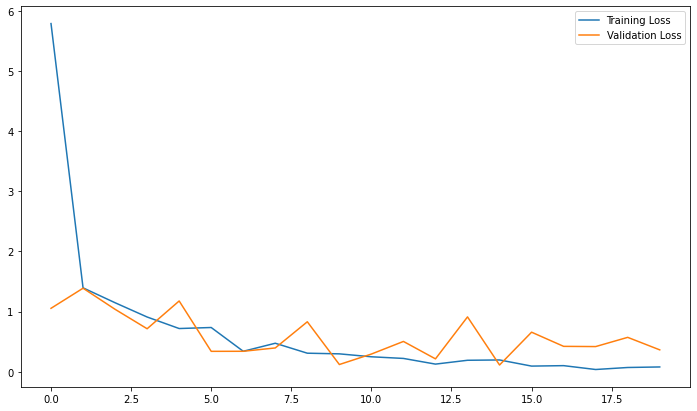

In [ ]:
# Plotting Loss

plt.plot(history.epoch, history.history['loss'], label='Training Loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss')
plt.legend()

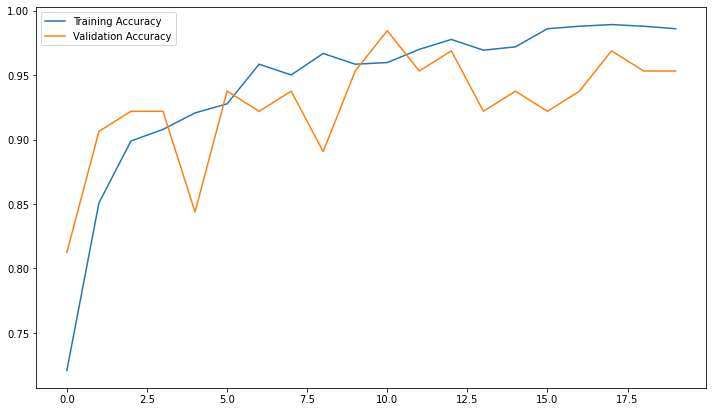

In [ ]:
# Plotting Accuracy

x_axis = range(epochs)

plt.plot(history.epoch, history.history['acc'], label='Training Accuracy')
plt.plot(history.epoch, history.history['val_acc'], label='Validation Accuracy')
plt.legend()

In [ ]:
# Loading the best model

model.load_weights('model_weights.hdf5')